In [1]:
!pip install einops transformers==4.35.2

In [2]:
import torch
from torch import Tensor, tensor, arange, randn, randint, tril, where, full_like, ones, allclose, empty, zeros, Storage, FloatTensor
from torch.nn import Module, Linear, GELU, ReLU, Parameter, Embedding, ModuleList, LayerNorm, MSELoss, KLDivLoss
from torch.nn.functional import softmax, cross_entropy
from torch.nn.init import zeros_
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from datasets import load_dataset, DatasetDict
# from transformer_lens import HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer
from dataclasses import dataclass
from typing import Optional, List, Dict, Callable
from einops import einsum
from tqdm import tqdm
import matplotlib.pyplot as plt
from os.path import isfile
from math import sqrt, pi, prod
from typing import Dict
import gc

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("using", device)

using cuda


In [4]:
@dataclass
class TransformerConfig:
    vocab_size: int
    ncontext: int
    dmodel: int
    dhead: int
    nhead: int
    dmlp : int
    nlayers: int
    activation_function: Callable = GELU()
    mask_value: float = 1e-5
    attention_scale: float = None

    def __post_init__(self):
        if self.attention_scale is None:
            self.attention_scale = 1 / sqrt(self.dhead)

def normalize(x, dim=-1, eps=1e-5):
    return x / (x.pow(2).mean(dim=dim, keepdim=True) + eps).sqrt()

# copied from https://github.com/huggingface/transformers/blob/main/src/transformers/activations.py
class NewGELUActivation(Module):
    def forward(self, input: Tensor) -> Tensor:
        return 0.5 * input * (1.0 + torch.tanh(sqrt(2.0 / pi) * (input + 0.044715 * torch.pow(input, 3.0))))

@dataclass
class BlockActivations:
    mid:       Optional[Tensor] = None
    post:      Optional[Tensor] = None
    attention: Optional[Tensor] = None
    mlp:       Optional[Tensor] = None

class IdentityAutoencoder(Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x, None

@dataclass
class BlockAutoencoders:
    mid:       Callable = IdentityAutoencoder()
    post:      Callable = IdentityAutoencoder()
    attention: Callable = IdentityAutoencoder()
    mlp:       Callable = IdentityAutoencoder()

class MLP(Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.up = Linear(cfg.dmodel, cfg.dmlp)
        self.down = Linear(cfg.dmlp, cfg.dmodel)

    def forward(self, x):
        x = self.up(x)
        x = self.cfg.activation_function(x)
        x = self.down(x)
        return x

class Attention(Module):
    def __init__(self, cfg):
        super().__init__()

        self.cfg = cfg

        self.query_weight  = Parameter(randn(cfg.nhead, cfg.dmodel, cfg.dhead) / sqrt(cfg.dmodel))
        self.key_weight    = Parameter(randn(cfg.nhead, cfg.dmodel, cfg.dhead) / sqrt(cfg.dmodel))
        self.value_weight  = Parameter(randn(cfg.nhead, cfg.dmodel, cfg.dhead) / sqrt(cfg.dmodel))
        self.output_weight = Parameter(randn(cfg.nhead, cfg.dhead, cfg.dmodel) / sqrt(cfg.nhead * cfg.dhead))

        self.query_bias    = Parameter(randn(cfg.nhead, cfg.dhead) / sqrt(cfg.dmodel))
        self.key_bias      = Parameter(randn(cfg.nhead, cfg.dhead) / sqrt(cfg.dmodel))
        self.value_bias    = Parameter(randn(cfg.nhead, cfg.dhead) / sqrt(cfg.dmodel))
        self.output_bias   = Parameter(randn(cfg.dmodel)           / sqrt(cfg.nhead * cfg.dhead))

    def forward(self, x):
        ncontext = x.size(-2)

        query = einsum(x, self.query_weight, "... ncontext dmodel, nhead dmodel dhead -> ... ncontext nhead dhead")
        key   = einsum(x, self.key_weight,   "... ncontext dmodel, nhead dmodel dhead -> ... ncontext nhead dhead")
        value = einsum(x, self.value_weight, "... ncontext dmodel, nhead dmodel dhead -> ... ncontext nhead dhead")
        query = query + self.query_bias
        key   = key   + self.key_bias
        value = value + self.value_bias

        attention = einsum(
            key,
            query,
            "... ncontext_key nhead dhead, ... ncontext_query nhead dhead -> ... nhead ncontext_query ncontext_key"
        )
        attention = self.cfg.attention_scale * attention
        attention_mask = tril(ones((ncontext, ncontext), dtype=torch.bool, device=device))
        attention = where(attention_mask, attention, tensor(self.cfg.mask_value, device=device))
        attention = softmax(attention, dim=-1)
        
        output = einsum(
            attention,
            value,
            "... nhead ncontext_query ncontext_key, ... ncontext_key nhead dhead -> ... ncontext_query nhead dhead"
        )
        result = einsum(output, self.output_weight, "... ncontext nhead dhead, nhead dhead dmodel -> ... ncontext dmodel")
        result = result + self.output_bias
        return result
    
@dataclass
class BlockOutput:
    output: Tensor
    activations: Optional[BlockActivations] = None
    autoencoder_activations: Optional[BlockActivations] = None

class TransformerBlock(Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.attention_layer_norm = LayerNorm(cfg.dmodel)
        self.mlp_layer_norm = LayerNorm(cfg.dmodel)

        self.attention = Attention(cfg)
        self.mlp = MLP(cfg)

    def forward(self, pre, return_activations=False, return_autoencoder_activations=False, autoencoders=BlockAutoencoders()):
        attention = self.attention(self.attention_layer_norm(pre))
        attention, autoencoder_attention = autoencoders.attention(attention)
        mid = pre + attention
        mid, autoencoder_mid = autoencoders.mid(mid)
        mlp = self.mlp(self.mlp_layer_norm(mid))
        mlp, autoencoder_mlp = autoencoders.mlp(mlp)
        post = mid + mlp
        post, autoencoder_post = autoencoders.post(post)

        return BlockOutput(
            output=                  post,
            activations=             BlockActivations(mid=mid, post=post, attention=attention, mlp=mlp) \
                                        if return_activations else None,
            autoencoder_activations= BlockActivations(mid=autoencoder_mid, post=autoencoder_post, attention=autoencoder_attention, mlp=autoencoder_mlp) \
                                        if return_autoencoder_activations else None
        )
    
@dataclass
class TransformerOutput:
    logits: Tensor
    activations: Optional[List[BlockActivations]] = None
    autoencoder_activations: Optional[List[BlockActivations]] = None

class Transformer(Module):
    def __init__(self, cfg, tokenizer=None):
        super().__init__()
        if type(cfg.activation_function) == str:
            cfg.activation_function = {"gelu": GELU(), "relu": ReLU(), "gelu_new": NewGELUActivation()}[cfg.activation_function]
        
        self.cfg = cfg
        self.tokenizer = tokenizer

        self.embedding = Embedding(cfg.vocab_size, cfg.dmodel)
        self.positional_embedding = Embedding(cfg.ncontext, cfg.dmodel)
        self.blocks = ModuleList([TransformerBlock(cfg) for _ in range(cfg.nlayers)])
        self.unembedding = Linear(cfg.dmodel, cfg.vocab_size)
        self.final_layer_norm = LayerNorm(cfg.dmodel)

    def forward(self, x, return_activations=False, return_autoencoder_activations=False, stop_at_layer=None, autoencoders: Dict[int, BlockAutoencoders] = dict()):
        if isinstance(x, str):
            x = self.tokenizer(x)

        x = self.embedding(x)
        ncontext = x.size(-2)
        x = x + self.positional_embedding(arange(ncontext, device=device))
        
        activations = [] if return_activations else None
        autoencoder_activations = [] if return_autoencoder_activations else None
        for layer, block in enumerate(self.blocks):
            block_autoencoders = autoencoders[layer] if layer in autoencoders else BlockAutoencoders()
            result = block(x, return_activations=True, return_autoencoder_activations=return_autoencoder_activations, autoencoders=block_autoencoders)
            x = result.output
            
            if return_activations:
                activations.append(result.activations)
            if return_autoencoder_activations:
                autoencoder_activations.append(result.autoencoder_activations)

            if stop_at_layer is not None and layer > stop_at_layer:
                break

        x = self.final_layer_norm(x)
        x = self.unembedding(x)
        
        return TransformerOutput(logits=x, activations=activations, autoencoder_activations=autoencoder_activations)

    @staticmethod
    def from_pretrained(pretrained_model_name, test=True, test_atol=1e-4):
        theirs = AutoModelForCausalLM.from_pretrained(pretrained_model_name) # .to(device)
        tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")

        ours = Transformer(TransformerConfig( vocab_size=          tokenizer.vocab_size,
                                              ncontext=            theirs.config.max_position_embeddings,
                                              dmodel=              theirs.config.hidden_size,
                                              dhead=               theirs.config.hidden_size // theirs.config.num_heads,
                                              nhead=               theirs.config.num_heads,
                                              dmlp=                4 * theirs.config.hidden_size,
                                              nlayers=             theirs.config.num_layers,
                                              activation_function= theirs.config.activation_function,
                                              attention_scale=     1.0,
                                              mask_value=          torch.finfo(torch.float).min )).to(device)
        
        ours.tokenizer = tokenizer

        with torch.no_grad():
            ours.embedding.weight.copy_(theirs.transformer.wte.weight)
            ours.positional_embedding.weight.copy_(theirs.transformer.wpe.weight)
            ours.unembedding.weight.copy_(theirs.transformer.wte.weight)
            zeros_(ours.unembedding.bias)
            ours.final_layer_norm.weight.copy_(theirs.transformer.ln_f.weight)
            ours.final_layer_norm.bias.copy_(theirs.transformer.ln_f.bias)
                    
            for layer in range(ours.cfg.nlayers):
                ours.blocks[layer].attention_layer_norm.weight.copy_(theirs.transformer.h[layer].ln_1.weight)
                ours.blocks[layer].attention_layer_norm.bias.copy_(theirs.transformer.h[layer].ln_1.bias)
                ours.blocks[layer].mlp_layer_norm.weight.copy_(theirs.transformer.h[layer].ln_2.weight)
                ours.blocks[layer].mlp_layer_norm.bias.copy_(theirs.transformer.h[layer].ln_2.bias)

                ours.blocks[layer].attention.query_weight.copy_(theirs.transformer.h[layer].attn.attention.q_proj.weight.reshape(ours.cfg.nhead, ours.cfg.dhead, ours.cfg.dmodel).permute(0, 2, 1))
                ours.blocks[layer].attention.key_weight.copy_(theirs.transformer.h[layer].attn.attention.k_proj.weight.reshape(ours.cfg.nhead, ours.cfg.dhead, ours.cfg.dmodel).permute(0, 2, 1))
                ours.blocks[layer].attention.value_weight.copy_(theirs.transformer.h[layer].attn.attention.v_proj.weight.reshape(ours.cfg.nhead, ours.cfg.dhead, ours.cfg.dmodel).permute(0, 2, 1))
                ours.blocks[layer].attention.output_weight.copy_(theirs.transformer.h[layer].attn.attention.out_proj.weight.reshape(ours.cfg.dmodel, ours.cfg.nhead, ours.cfg.dhead).permute(1, 2, 0))

                zeros_(ours.blocks[layer].attention.query_bias)
                zeros_(ours.blocks[layer].attention.key_bias)
                zeros_(ours.blocks[layer].attention.value_bias)
                ours.blocks[layer].attention.output_bias.copy_(theirs.transformer.h[layer].attn.attention.out_proj.bias)

                ours.blocks[layer].mlp.up.weight.copy_(theirs.transformer.h[layer].mlp.c_fc.weight)
                ours.blocks[layer].mlp.down.weight.copy_(theirs.transformer.h[layer].mlp.c_proj.weight)

                ours.blocks[layer].mlp.up.bias.copy_(theirs.transformer.h[layer].mlp.c_fc.bias)
                ours.blocks[layer].mlp.down.bias.copy_(theirs.transformer.h[layer].mlp.c_proj.bias)
            

        if test:
            with torch.no_grad():
                print("Testing that the model behaves the same as the library model... ", end="", flush=True)
                inputs = randint(0, ours.cfg.vocab_size, (64, 64), device=device)
                assert allclose(ours(inputs).logits, theirs(inputs).logits, atol=test_atol), "Tests failed!"
                print("Test passed!")

        return ours
    
        """
        theirs = HookedTransformer.from_pretrained(pretrained_model_name)
        
        ours = Transformer(TransformerConfig( vocab_size=theirs.tokenizer.vocab_size,
                                      ncontext=theirs.cfg.n_ctx,
                                      dmodel=theirs.cfg.d_model,
                                      dhead=theirs.cfg.d_head,
                                      nhead=theirs.cfg.n_heads,
                                      dmlp=theirs.cfg.d_mlp,
                                      nlayers=theirs.cfg.n_layers,
                                      activation_function=theirs.cfg.act_fn ))

        ours.tokenizer = theirs.tokenizer

        with torch.no_grad():
            ours.embedding.weight.copy_(theirs.embed.W_E)
            ours.positional_embedding.weight.copy_(theirs.pos_embed.W_pos)
            ours.unembedding.weight.copy_(theirs.unembed.W_U.transpose(0, 1))
            ours.unembedding.bias.copy_(theirs.unembed.b_U)
            
            for layer in range(ours.cfg.nlayers):
                ours.blocks[layer].attention.query_weight.copy_(theirs.blocks[layer].attn.W_Q)
                ours.blocks[layer].attention.key_weight.copy_(theirs.blocks[layer].attn.W_K)
                ours.blocks[layer].attention.value_weight.copy_(theirs.blocks[layer].attn.W_V)
                ours.blocks[layer].attention.output_weight.copy_(theirs.blocks[layer].attn.W_O)

                ours.blocks[layer].attention.query_bias.copy_(theirs.blocks[layer].attn.b_Q)
                ours.blocks[layer].attention.key_bias.copy_(theirs.blocks[layer].attn.b_K)
                ours.blocks[layer].attention.value_bias.copy_(theirs.blocks[layer].attn.b_V)
                ours.blocks[layer].attention.output_bias.copy_(theirs.blocks[layer].attn.b_O)

                ours.blocks[layer].mlp.up.weight.copy_(theirs.blocks[layer].mlp.W_in.transpose(0, 1))
                ours.blocks[layer].mlp.down.weight.copy_(theirs.blocks[layer].mlp.W_out.transpose(0, 1))

                ours.blocks[layer].mlp.up.bias.copy_(theirs.blocks[layer].mlp.b_in)
                ours.blocks[layer].mlp.down.bias.copy_(theirs.blocks[layer].mlp.b_out)

        return ours
        """

In [5]:
model = Transformer.from_pretrained("roneneldan/TinyStories-1M", test=False).to(device)
model.eval()

Transformer(
  (embedding): Embedding(50257, 64)
  (positional_embedding): Embedding(2048, 64)
  (blocks): ModuleList(
    (0): TransformerBlock(
      (attention_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attention): Attention()
      (mlp): MLP(
        (up): Linear(in_features=64, out_features=256, bias=True)
        (down): Linear(in_features=256, out_features=64, bias=True)
      )
    )
    (1): TransformerBlock(
      (attention_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attention): Attention()
      (mlp): MLP(
        (up): Linear(in_features=64, out_features=256, bias=True)
        (down): Linear(in_features=256, out_features=64, bias=True)
      )
    )
    (2): TransformerBlock(
      (attention_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
   

In [6]:
def train_val_test_split(dataset, val_size=0.1, test_size=0.1):
    # assert set(dataset.keys()) == {"train"}
    dataset = dataset.train_test_split(test_size=val_size+test_size)
    val_test_dataset = dataset["test"].train_test_split(test_size = val_size / (val_size + test_size))
    return DatasetDict({ "train": dataset["train"],
                         "val":   val_test_dataset["train"],
                         "test":  val_test_dataset["test"] })

def make_tokens_dataset(text_dataset, tokenizer, ncontext, _tqdm=True, max_size=None, save_to=None):
    if save_to is not None and isfile(save_to):
        print(f"Loading tokens dataset from file '{save_to}'.")
        return torch.load(save_to)
    
    if _tqdm and max_size is not None:
        print("WARNING: tqdm doesn't work properly when max_size is not None")

    token_seqs = []
    for x in tqdm(text_dataset) if _tqdm else text_dataset:
        tokens = tokenizer(x["text"])["input_ids"]
        if len(tokens) <= ncontext:
            continue
        tokens = tokens[:ncontext]
        token_seqs.append(tokens)
        
        if max_size is not None and len(token_seqs) >= max_size:
            break
    
    dataset = TensorDataset(tensor(token_seqs, requires_grad=False))

    if save_to is not None:
        torch.save(dataset, save_to)

    return dataset

class BlockActivationsDataset(Dataset):
    def __init__(self, activations: BlockActivations):
        self.activations = activations

    def __len__(self):
        for attr in ["mid", "post", "attention", "mlp"]:
            activation = getattr(self.activations, attr)
            if activation is not None:
                return activation.size(0)
        assert False

    def __getitem__(self, index):
        slice = BlockActivations(None, None, None, None)
        for attr in ["mid", "post", "attention", "mlp"]:
            activation = getattr(self.activations, attr)
            if activation is not None:
                setattr(slice, attr, activation[index])
        return slice

class ActivationsDataset(Dataset):
    def __init__(self, activations: Dict[int, BlockActivations]):
        self.activations = { layer: BlockActivationsDataset(layer_activations)
                             for layer, layer_activations in activations.items() }

    def __len__(self):
        return len(next(iter(self.activations.values())))
    
    def __getitem__(self, index):
        return {layer: activations[index] for layer, activations in self.activations.items()}

def block_activations_collate_fn(activations: List[BlockActivations]):
    checkpoints = [checkpoint for checkpoint in ["mid", "post", "attention", "mlp"] if getattr(activations[0], checkpoint) is not None]
    shape = (len(activations), *getattr(activations[0], checkpoints[0]).shape)
    result = BlockActivations(**{checkpoint: empty(shape, device=device, requires_grad=False) for checkpoint in checkpoints})
    for i, acts in enumerate(activations):
        for checkpoint in checkpoints:
            getattr(result, checkpoint)[i] = getattr(acts, checkpoint)
    return result

def activations_collate_fn(activations: List[Dict[int, BlockActivations]]):
    return {layer: block_activations_collate_fn([acts[layer] for acts in activations]) for layer in activations[0].keys()}

def make_activation_dataset(model, dataloader, layers, checkpoints, _tqdm=True, on_disk=False, storage_root_directory=None):
    def storage_filename(layer, checkpoint):
        assert storage_root_directory is not None
        return f"{storage_root_directory}/activations-layer{layer}-{checkpoint}.dat"

    def make_activations_storage(layer, checkpoint):
        shape = (len(dataloader.dataset), *output.activations[0].mid.shape[1:])
        if on_disk:
            return FloatTensor(Storage.from_file(storage_filename(layer, checkpoint), shared=True, size=prod(shape))).reshape(shape)
        else:
            return empty(shape)

    with torch.no_grad():
        all_activations = None
        i = 0
        for data, in tqdm(dataloader) if _tqdm else dataloader:
            output = model(data.to(device), return_activations=True, stop_at_layer=max(layers))
            
            if all_activations is None:
                all_activations = { layer: BlockActivations(**{checkpoint: make_activations_storage(layer, checkpoint) for checkpoint in checkpoints})
                                    for layer in layers }
                
            batch_size = output.activations[0].mid.size(0)
            for layer in layers:
                for checkpoint in checkpoints:
                    getattr(all_activations[layer], checkpoint)[i:i+batch_size] = getattr(output.activations[layer], checkpoint).cpu()
            
            i += batch_size

    dataset = ActivationsDataset(all_activations)
    assert i == len(dataset)

    return dataset

In [7]:
dataset = load_dataset("roneneldan/TinyStories")
val_test_dataset = dataset["validation"].train_test_split(test_size=0.5)
train_dataset = dataset["train"]
val_dataset   = val_test_dataset["train"]
test_dataset  = val_test_dataset["test"]

Using custom data configuration roneneldan--TinyStories-a62fc98e062666ca
Reusing dataset parquet (/root/.cache/huggingface/datasets/roneneldan___parquet/roneneldan--TinyStories-a62fc98e062666ca/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
tokens_dataset = make_tokens_dataset(train_dataset, model.tokenizer, ncontext=250, save_to="/storage/tokens_dataset.pickle") # "/home/paperspace/tokens_dataset.pickle")
tokens_dataset = Subset(tokens_dataset, range(100_000)) # not enough ram :( and waiting for access to a machine with a big disk
tokens_dataloader = DataLoader(tokens_dataset, batch_size=64, shuffle=True)

val_tokens_dataset = make_tokens_dataset(val_dataset, model.tokenizer, ncontext=250, save_to="/storage/val_tokens_dataset.pickle")# "/home/paperspace/val_tokens_dataset.pickle")
val_tokens_dataloader = DataLoader(val_tokens_dataset, batch_size=64)

activations_dataset = make_activation_dataset(model, tokens_dataloader, layers=[0], checkpoints=["mlp"], on_disk=False)# on_disk=True, storage_root_directory="/home/paperspace/activations/")
activations_dataloader = DataLoader(activations_dataset, batch_size=4096, collate_fn=activations_collate_fn)

val_activations_dataset = make_activation_dataset(model, val_tokens_dataloader, layers=[0], checkpoints=["mlp"], on_disk=False)
activations_dataloader = DataLoader(activations_dataset, batch_size=4096, collate_fn=activations_collate_fn)

Loading tokens dataset from file '/storage/tokens_dataset.pickle'.
Loading tokens dataset from file '/storage/val_tokens_dataset.pickle'.


100%|██████████| 1563/1563 [01:21<00:00, 19.20it/s]


TypeError: make_activation_dataset() got an unexpected keyword argument 'checkpoint'

In [10]:
class SparseAutoencoder(Module):
    def __init__(self, d, dhidden, activation_function=ReLU()):
        super().__init__()
        self.pre_bias = Parameter(zeros(d))
        self.up = Linear(d, dhidden)
        self.activation_function = activation_function
        self.down = Linear(dhidden, d)

    def forward(self, x):
        hidden = self.up(x - self.pre_bias)
        hidden = self.activation_function(hidden)
        output = self.down(hidden)
        return output, hidden

class L1Penalty(Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.norm(dim=-1, p=1).mean()

In [11]:
def train_sparse_autoencoder( sparse_autoencoder,
                              activations_dataloader,
                              layer,
                              checkpoint,
                              epochs,
                              sparsity_penalty_weight,
                              reconstruction_loss_fn=MSELoss(),
                              sparsity_penalty_fn=L1Penalty(),
                              optimizer=None,
                              epoch_tqdm=True,
                              batch_tqdm=False,
                              plot=True ):
    if optimizer is None:
        optimizer = AdamW(sparse_autoencoder.parameters(), lr=1e-4)
    
    reconstruction_loss_history = []
    sparsity_penalty_history = []
    for epoch in tqdm(range(epochs)) if epoch_tqdm else range(epochs):
        epoch_reconstruction_loss = 0
        epoch_sparsity_penalty = 0
        for activations in tqdm(activations_dataloader) if batch_tqdm else activations_dataloader:
            activations = getattr(activations[layer], checkpoint).detach()
            reconstructed, hidden = sparse_autoencoder(activations)
            reconstruction_loss = reconstruction_loss_fn(reconstructed, activations)
            sparsity_penalty = sparsity_penalty_fn(hidden)
            loss = reconstruction_loss + sparsity_penalty_weight * sparsity_penalty
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_reconstruction_loss += reconstruction_loss.item()
            epoch_sparsity_penalty += sparsity_penalty.item()

        reconstruction_loss_history.append(epoch_reconstruction_loss / len(activations_dataloader))
        sparsity_penalty_history.append(epoch_sparsity_penalty / len(activations_dataloader))

    if plot:
        plt.title("Sparse autoencoder training loss")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.yscale("log")
        plt.plot(reconstruction_loss_history, label="reconstruction loss")
        plt.plot(sparsity_penalty_history, label="sparsity penalty")
        plt.legend()
        plt.show()

def test_sparse_autoencoder(model, dataloader, autoencoder, layer, checkpoint, reconstruction_loss_fn=KLDivLoss(), sparsity_penalty_fn=L1Penalty(), _tqdm=True):
    autoencoders = {layer: BlockAutoencoders(**{checkpoint: autoencoder})}

    with torch.no_grad():
        reconstruction_loss = 0
        sparsity_penalty = 0
        for tokens, in tqdm(dataloader) if _tqdm else dataloader:
            tokens = tokens.to(device)
            result = model(tokens)
            result_with_autoencoders = model(tokens, autoencoders=autoencoders, return_autoencoder_activations=True)
            reconstruction_loss += reconstruction_loss_fn(result.logits, result_with_autoencoders.logits)
            autoencoder_activaitons = getattr(result_with_autoencoders.autoencoder_activations[layer], checkpoint)
            sparsity_penalty += sparsity_penalty_fn(autoencoder_activaitons)
            gc.collect()
            torch.cuda.empty_cache()
        reconstruction_loss /= len(dataloader)
        sparsity_penalty /= len(dataloader)
        
    return {"reconstruction_loss": reconstruction_loss, "sparsity_penalty": sparsity_penalty}

100%|██████████| 200/200 [24:29<00:00,  7.35s/it]


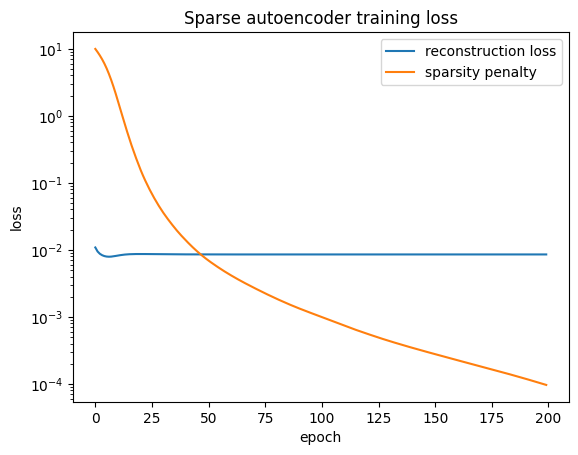

100%|██████████| 1957/1957 [00:16<00:00, 121.21it/s]


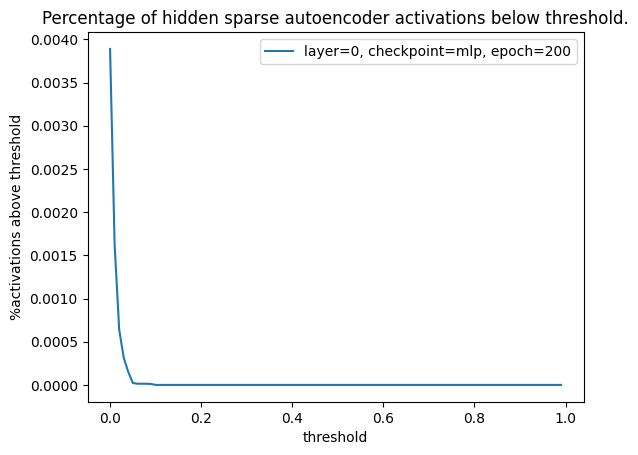

100%|██████████| 200/200 [24:56<00:00,  7.48s/it]


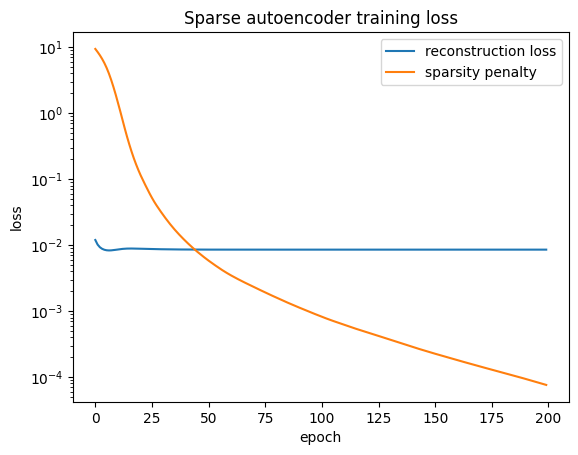

100%|██████████| 1957/1957 [00:15<00:00, 126.79it/s]


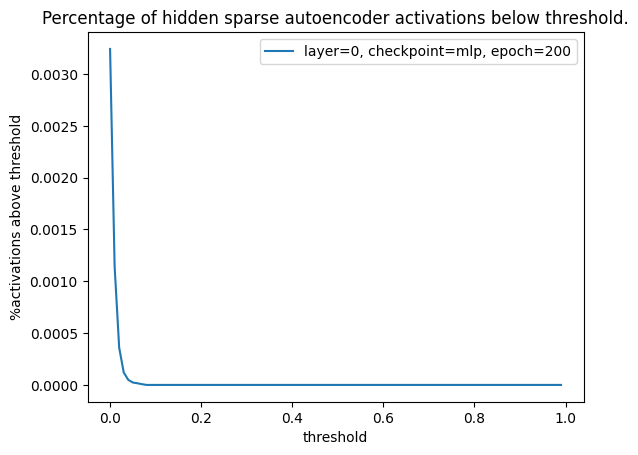

100%|██████████| 200/200 [24:39<00:00,  7.40s/it]


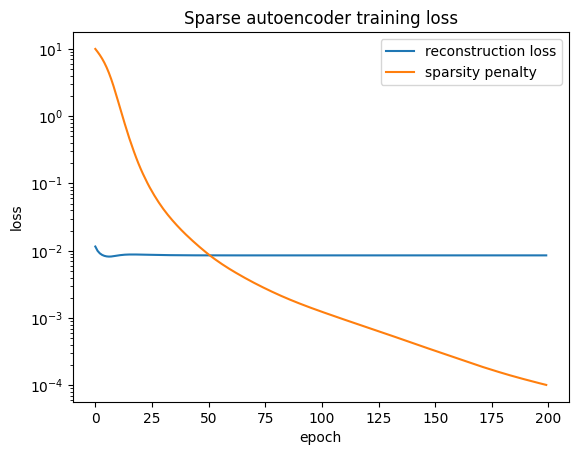

100%|██████████| 1957/1957 [00:15<00:00, 128.35it/s]


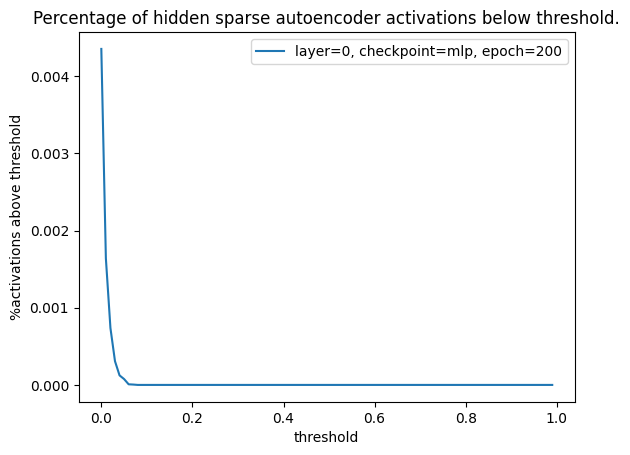

100%|██████████| 200/200 [24:47<00:00,  7.44s/it]


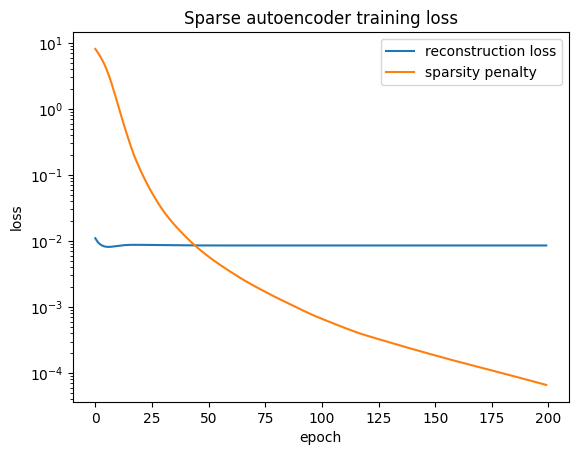

100%|██████████| 1957/1957 [00:15<00:00, 127.59it/s]


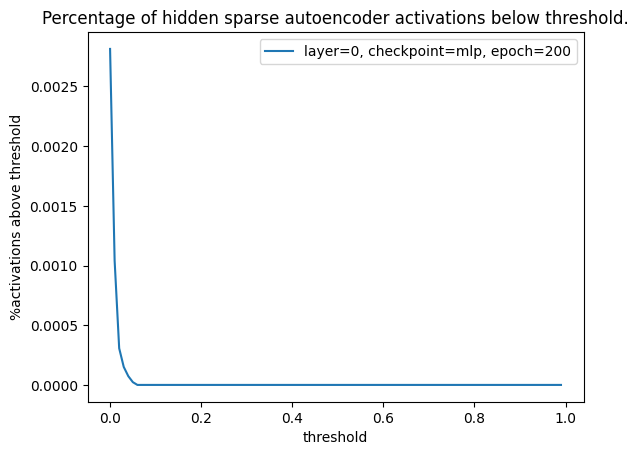

 64%|██████▎   | 127/200 [15:53<09:10,  7.55s/it]

In [16]:
for sparsity_penalty_weight in [1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]:
    sparse_autoencoder = SparseAutoencoder(model.cfg.dmodel, 4*model.cfg.dmodel).to(device)
    train_sparse_autoencoder(sparse_autoencoder, activations_dataloader, layer=0, checkpoint="mlp", epochs=200, sparsity_penalty_weight=sparsity_penalty_weight)

    thresholds = [x.item() for x in torch.arange(0, 1, 0.01)]
    densities = [0 for _ in thresholds]
    total_acts = 0
    for activations in tqdm(val_activations_dataset):
        _, hidden = sparse_autoencoder(activations[0].mlp.to(device))
        for i, threshold in enumerate(thresholds):
            densities[i] += (hidden > threshold).sum().item()
        total_acts += hidden.numel()
    densities = [d / total_acts * 100 for d in densities]

    plt.title("Percentage of hidden sparse autoencoder activations below threshold.")
    plt.xlabel("threshold")
    plt.ylabel("%activations above threshold")
    plt.plot(thresholds, densities, label="layer=0, checkpoint=mlp, epoch=200")
    plt.legend()
    plt.show()

100%|██████████| 100/100 [12:15<00:00,  7.35s/it]


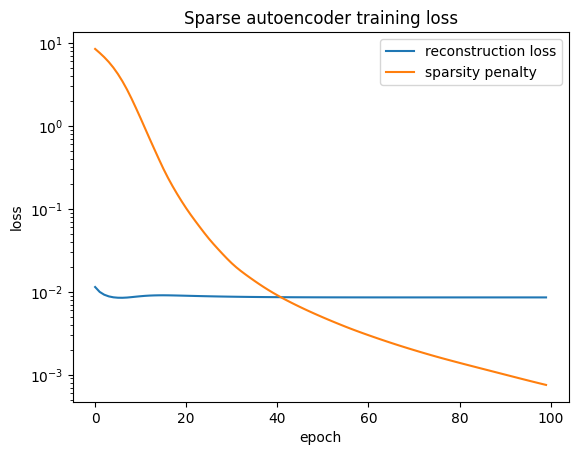

In [ ]:
sparse_autoencoder = SparseAutoencoder(model.cfg.dmodel, 4*model.cfg.dmodel).to(device)
train_sparse_autoencoder(sparse_autoencoder, activations_dataloader, layer=0, checkpoint="mlp", epochs=250, sparsity_penalty_weight=1e-5)

100%|██████████| 1957/1957 [00:15<00:00, 128.94it/s]


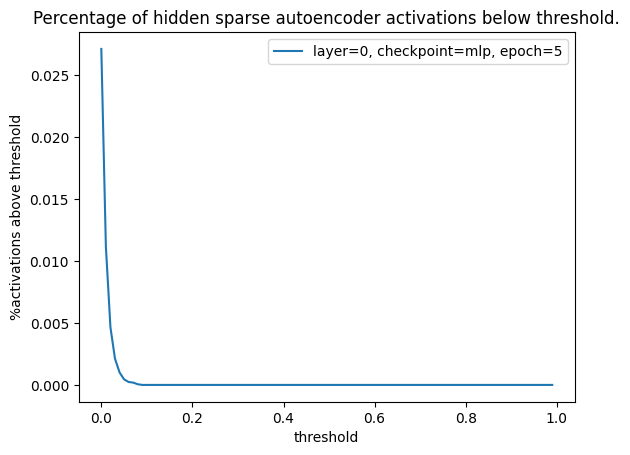

In [ ]:
thresholds = [x.item() for x in torch.arange(0, 1, 0.01)]
densities = [0 for _ in thresholds]
total_acts = 0
for activations in tqdm(val_activations_dataset):
    _, hidden = sparse_autoencoder(activations[0].mlp.to(device))
    for i, threshold in enumerate(thresholds):
        densities[i] += (hidden > threshold).sum().item()
    total_acts += hidden.numel()
densities = [d / total_acts * 100 for d in densities]

plt.title("Percentage of hidden sparse autoencoder activations below threshold.")
plt.xlabel("threshold")
plt.ylabel("%activations above threshold")
plt.plot(thresholds, densities, label="layer=0, checkpoint=mlp, epoch=5")
plt.legend()
plt.show()

In [53]:
gc.collect()
torch.cuda.empty_cache()

In [21]:
test_sparse_autoencoder(model, val_tokens_dataloader, sparse_autoencoder, layer=0, checkpoint="mlp")

  0%|          | 0/1957 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:2904: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
  6%|▋         | 123/1957 [00:27<06:44,  4.54it/s]


RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 23.87 GiB total capacity; 23.18 GiB already allocated; 45.12 MiB free; 23.19 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# training the model - don't look at it, we will only train the model from scratch if we have time

In [ ]:
def next_token_logits(model, seq):
    return model(seq)[..., -1, :]

In [ ]:
def repetition_dataset(vocab_size, ncontext, size):
    assert ncontext % 2 == 1
    data = randint(vocab_size, (size, (ncontext + 1) // 2), device=device)
    data = data.repeat(1, 2)
    return TensorDataset(data)

In [ ]:
def transformer_cross_entropy_loss(pred, true):
    return cross_entropy(pred.transpose(1, -1), true.transpose(1, -1))

In [ ]:
def train(model, dataloader, epochs, loss_fn=transformer_cross_entropy_loss, lr=1e-3, epoch_tqdm=True, batch_tqdm=False, plot_loss=True):
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)
    
    loss_history = []
    for epoch in tqdm(range(epochs)) if epoch_tqdm else range(epochs):
        for x, in tqdm(dataloader) if batch_tqdm else dataloader:
            optimizer.zero_grad()
            loss = loss_fn(model(x[..., :-1]), x[..., 1:])
            loss_history.append(loss.item())
            loss.backward()
            optimizer.step()

    if plot_loss:
        plt.title("training_loss")
        plt.xlabel("training iteration")
        plt.ylabel("loss")
        plt.yscale("log")
        plt.plot(loss_history)
        plt.show()

In [ ]:
cfg = TransformerConfig(vocab_size=10, ncontext=17, dmodel=16, dhead=4, nhead=4, dmlp=32, nlayers=2)
train_dataloader = DataLoader(repetition_dataset(vocab_size=cfg.vocab_size, ncontext=cfg.ncontext, size=500_000), batch_size=64, shuffle=True)
model = Transformer(cfg).to(device)
train(model, train_dataloader, epochs=1, batch_tqdm=True, epoch_tqdm=False)

  0%|          | 6/7813 [00:00<02:24, 54.04it/s]

  7%|▋         | 552/7813 [00:05<01:18, 92.57it/s] 


KeyboardInterrupt: 

In [ ]:
test_dataloader = DataLoader(repetition_dataset(vocab_size=cfg.vocab_size, ncontext=cfg.ncontext, size=1_000), batch_size=64, shuffle=True)
x, = next(iter(test_dataloader))
model(x[0, :2])
print(x.shape)
print(model(x[..., :-1]).argmax(-1)[0, ...])
print(x[..., 1:][0, ...])
print(x[..., :-1][0, ...])
print(transformer_cross_entropy_loss(model(x[..., :-1]), x[..., 1:]))

torch.Size([64, 18])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 2, 5, 2, 1, 3, 1, 6])
tensor([8, 2, 5, 2, 1, 3, 1, 6, 1, 8, 2, 5, 2, 1, 3, 1, 6])
tensor([1, 8, 2, 5, 2, 1, 3, 1, 6, 1, 8, 2, 5, 2, 1, 3, 1])
tensor(1.0842, grad_fn=<NllLoss2DBackward0>)
